## E-9 Computer Vision Project


1-1. VGG16 모델 구현하기
영상의 내용을 참고하여 직접 코드로 모델을 구현. Batch Normalization, Parameter Initialization 등을 사용할 수도.


1-2. 다양한 방법을 사용하여 모델의 성능 올리기
skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보자.

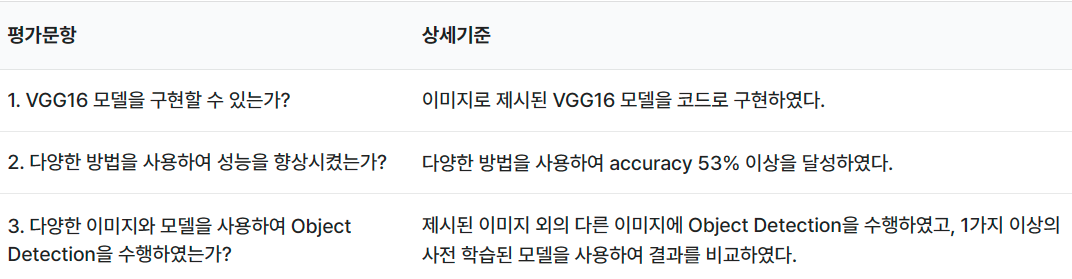

## 9-2. 프로젝트 1: Image Classification

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

- 데이터를 준비. 불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정. test 데이터에서 1은 개, 0은 고양이를 의미.

- 여러분들이 원하는 이미지 데이터를 불러 Classification을 해보는 것도 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

- train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장.

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


- 고양이, 개 각각 train, validation directory에 Q 머한거?

In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


- train 데이터와 validation 데이터의 개수를 알아봄

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val) # 고양이 사진 1천개, 개 사진 1천개, 검증data 고양이, 개 500개, 총 훈련data 2000개 검증 총 1000개

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# parameter Initialization 파라미터 설정
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

- 이미지를 확인하기 위해 데이터를 시각화하는 함수를 만듬. 간단한 함수이기 때문에 자세한 코드 설명은 생략. 궁금하면 구글

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

- train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘림.

- Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 함.

In [8]:
# Training data generator : data양 늘리려고 한사진으로 여러개 만듬. 
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3, # 30% 이미지를 수평으로 뒤집음. 케창딥 307p
                                     width_shift_range=0.1, # -10% ~ 10% 좌우이동
                                     height_shift_range=0.1,# -10%~ 10% 상하이동
                                     zoom_range=0.2,# -20% ~ 20% 확대, 축소 
                                     horizontal_flip=True, # 사진 좌우 뒤집은거.
                                     vertical_flip=False) # 사진 상하 뒤집은거,  

- .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결. 개와 고양이를 분류하는 task를 수행하기 때문에 class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


- Data Augmentation이 제대로 되었는지 확인

In [10]:
train_data_gen[0][0].shape #Q 아래숫자 뭔뜻, 이미지? input_layer=tf.keras.layers.Input(shape=(256, 256, 3)) -> 256*256픽셀의 컬러(3채널,rgb) 이미지를 받아들이는 층

(16, 256, 256, 3)

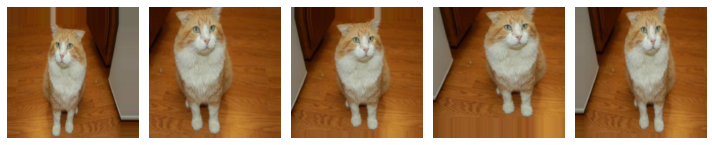

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)  # Q  이미지 추가 시킨거? 이미지 2000장이라 적다고?  augmented 증가된

- Validation 데이터에도 train 데이터와 같은 동일한 작업. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255) # 스케일 변경

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary') # 2class에 이미지 1000개

Found 1000 images belonging to 2 classes.


- Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성

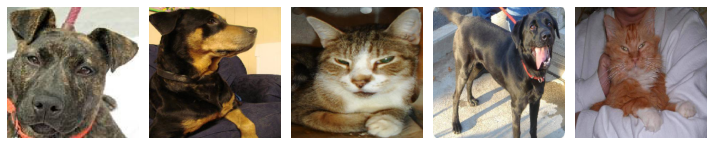

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5]) #Q. 아래 어디 이미지와 정답 data ? 그냥 샘플 이미지들


In [15]:
_[:5] # 정답 데이터 그냥 0, 1의 array네

array([1., 1., 0., 1., 0.], dtype=float32)

## 1-1. VGG16 모델 구현하기

-  VGG16 모델의 구조를 다시 상기해 보고, 코드로 직접 구현.

- 참고: 예시 코드는 아래에 제공되어 있지만 예시 코드는 위에서 제공한 이미지의 VGG16 모델을 그대로 구현X. 예시 코드를 참고하여 VGG16 모델을 구현

In [16]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928 

- 손실함수, optimizer, metric을 설정해 줍니다.

- 손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있다. optimizer도 Adam 외에 다양한 것을 사용할 수 있다. 자유롭게 바꿔봐

In [17]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습에 활용. 

- https://velog.io/@ym980118/%EB%94%A5%EB%9F%AC%EB%8B%9D-Callback 콜백은 모델을 fit한 뒤, iteration 할 때마다 특정한 이벤트에 따라 callback이 수행되는 것을 말합니다. 주로 learning_rate를 수정할 때 사용

- Callback 종류!
1.ModelCheckpoint 2. ReduceLROnPlateau : learning_rate를 동적으로 감소시킴. 3. EarlyStopping 


## 모델 학습을 시켜봄.

- data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환.


- batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야. Q batch가 뭘 생성되? 있는 data, batch만큼 넣는거 아님?

- 만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다. 

- 일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정
  * https://foxtrotin.tistory.com/535 steps_per_epoch = 훈련샘플 수/배치사이즈 총45개의 훈련 샘플이 있고 배치사이즈가 3이면 최대15 스텝으로 지정

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    # callbacks=callbacks_list,
    validation_freq=1) 

Epoch 1/5
125/125 [==============================] - 38s 261ms/step - loss: 35.6778 - binary_accuracy: 0.5230 - val_loss: 0.6943 - val_binary_accuracy: 0.5010
Epoch 2/5
125/125 [==============================] - 32s 252ms/step - loss: 0.7505 - binary_accuracy: 0.4895 - val_loss: 0.6964 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 31s 247ms/step - loss: 0.6958 - binary_accuracy: 0.5015 - val_loss: 0.6957 - val_binary_accuracy: 0.4980
Epoch 4/5
125/125 [==============================] - 31s 248ms/step - loss: 0.6927 - binary_accuracy: 0.5005 - val_loss: 0.6957 - val_binary_accuracy: 0.4980
Epoch 5/5
125/125 [==============================] - 31s 250ms/step - loss: 0.6946 - binary_accuracy: 0.5035 - val_loss: 0.6927 - val_binary_accuracy: 0.4970


## 학습이 되었다면 시각화를 통해 정확도를 알아봄.


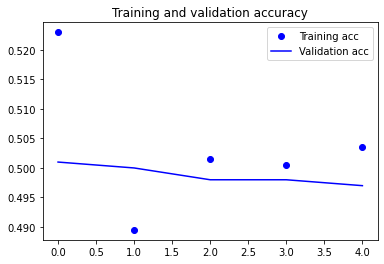

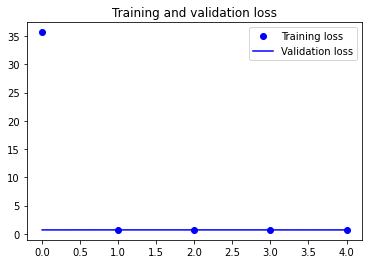

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 1-2. 다양한 방법을 사용하여 모델의 성능 올리기


- hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 50% 이상으로 높일 수 있다. 다양한 실험을 통해 성능을 올려 보자.

In [20]:
batch_size = 16
epochs = 13
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [21]:
# Training data generator :  data양 늘리려고 한사진으로 여러개 만듬.
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3, # 30% 사진 돌림
                                     width_shift_range=0.2, # -20% ~ 20% 좌우이동
                                     height_shift_range=0.3, # -30% ~ 30% 상하이동
                                     zoom_range=0.3,         # -30% ~ 30% 확대, 축소 
                                     horizontal_flip=True,   # 사진 좌우 뒤집은거.
                                     vertical_flip=True)     # 사진 상하 뒤집은거

In [22]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


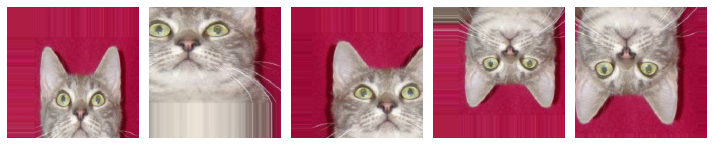

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [24]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x) # 이진분류라 1과 sigmoid 해야 함. 

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 128)     512 

In [25]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [26]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/13
125/125 [==============================] - 44s 300ms/step - loss: 0.9499 - binary_accuracy: 0.5405 - val_loss: 0.7613 - val_binary_accuracy: 0.5000
Epoch 2/13
125/125 [==============================] - 36s 284ms/step - loss: 0.7432 - binary_accuracy: 0.5730 - val_loss: 0.7174 - val_binary_accuracy: 0.5000
Epoch 3/13
125/125 [==============================] - 35s 279ms/step - loss: 0.6911 - binary_accuracy: 0.6010 - val_loss: 0.7213 - val_binary_accuracy: 0.4990
Epoch 4/13
125/125 [==============================] - 36s 285ms/step - loss: 0.6936 - binary_accuracy: 0.6040 - val_loss: 0.9060 - val_binary_accuracy: 0.5280
Epoch 5/13
125/125 [==============================] - 36s 286ms/step - loss: 0.6584 - binary_accuracy: 0.6190 - val_loss: 0.6825 - val_binary_accuracy: 0.6200
Epoch 6/13
125/125 [==============================] - 36s 283ms/step - loss: 0.6518 - binary_accuracy: 0.6395 - val_loss: 0.7182 - val_binary_accuracy: 0.6220
Epoch 7/13
125/125 [==========================

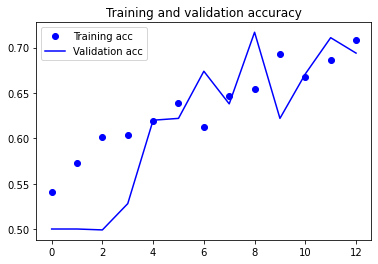

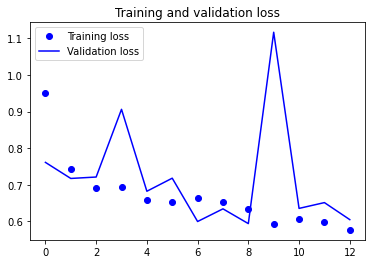

In [27]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 시행착오들

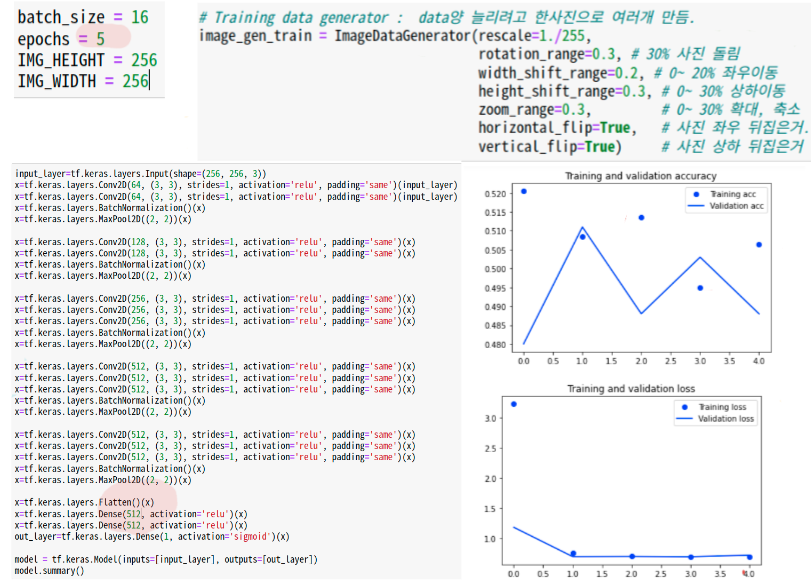

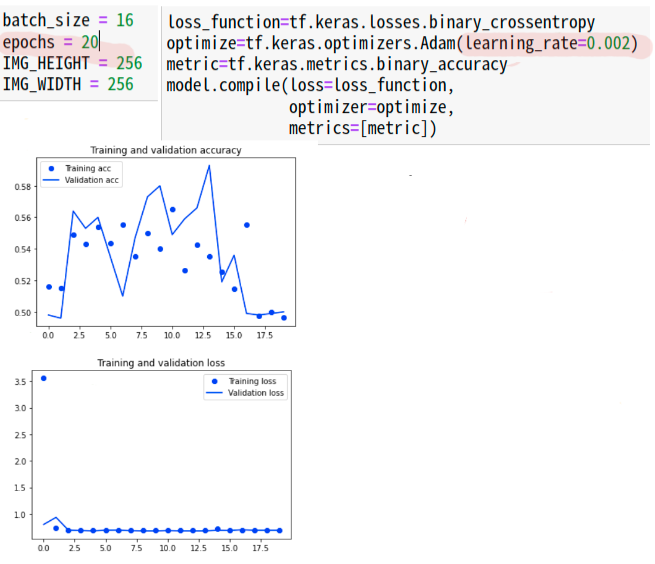

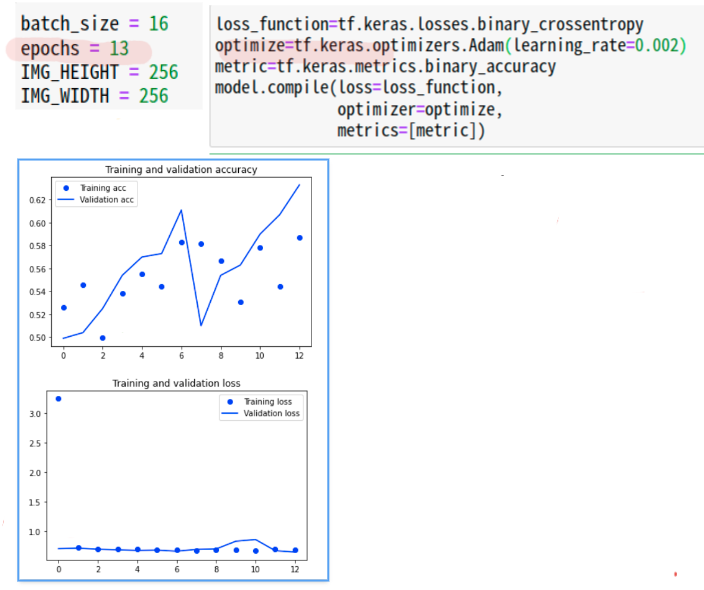

## Reference

- https://velog.io/@ym980118/%EB%94%A5%EB%9F%AC%EB%8B%9D-Callback 


- https://foxtrotin.tistory.com/535 steps_per_epoch 


- https://velog.io/@whiteamericano/R-CNN-%EC%9D%84-%EC%95%8C%EC%95%84%EB%B3%B4%EC%9E%90 RCNN 

## 회고 

- 학습률을 0,002에서 0.0001로 낮췄더니 accuracy가 62% 에서 70%까지 올라감.

- epoch 횟수를 늘리는것보다 과대적합 위치를 찾아내는것 필요. 